# Fitting models and overfitting

Original Notebooks courtesy of Prof. Foster Provost and Rubing Li
***

In [2]:
# Import the libraries we will be using

import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')


## Data: Predicting wine quality

_"All wines should be tasted; some should only be sipped, but with others, drink the whole bottle."_ - Paulo Coelho, Brida

We will use a data set related to the red variant of the Portuguese "Vinho Verde" wine. We will predict the "sensory" output based on physicochemical inputs.  (Here there is no data about grape types, wine brand, wine selling price, etc.). Our goal is to use machine learning to detect above-average wines (perhaps to send these wines later to professional tasters?).

Let's start by loading the data.

In [3]:
# in this case, we can read the data direct from a URL, no download/upload required!

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_df = pd.read_csv(url, delimiter=";").dropna()
wine_df


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
wine_df.describe().round(2)

# no missing values!!

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00
mean,8.32,0.53,0.27,2.54,0.09,15.87,46.47,1.00,3.31,0.66,10.42,5.64
std,1.74,0.18,0.19,1.41,0.05,10.46,32.90,0.00,0.15,0.17,1.07,0.81
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40,3.00
25%,7.10,0.39,0.09,1.90,0.07,7.00,22.00,1.00,3.21,0.55,9.50,5.00
50%,7.90,0.52,0.26,2.20,0.08,14.00,38.00,1.00,3.31,0.62,10.20,6.00
75%,9.20,0.64,0.42,2.60,0.09,21.00,62.00,1.00,3.40,0.73,11.10,6.00
max,15.90,1.58,1.00,15.50,0.61,72.00,289.00,1.00,4.01,2.00,14.90,8.00


Now, let's turn this into a classification problem -  our goal is to identify above-average wines, not accurately predict the quality score.  We create a binary "is_good" attribute if the quality is greater than the mean (aka `quality >= 6`)

In [5]:
avg_quality = wine_df.quality.mean()
wine_df["is_good"] = wine_df.quality > avg_quality
wine_df.is_good.value_counts()


,count
is_good,
True,855
False,744


In [6]:
# lets do some data cleanup

# we can remove the original feature, quality

wine_df = wine_df.drop("quality", axis="columns")

# Lets make column names easier to work with - replace white spaces with underscores

wine_df.columns = [c.replace(' ', '_') for c in wine_df.columns]
wine_df.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_good
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,False
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,False
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,False
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,True
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,False


In [7]:
# Now let's set ourselves up for predictive modeling
# Identify the predictor (X) columns
column_names = wine_df.columns
predictor_columns = column_names[:-1] # this removes the last column

Let's explore whether any of the features seem to be very predictive by themselves.

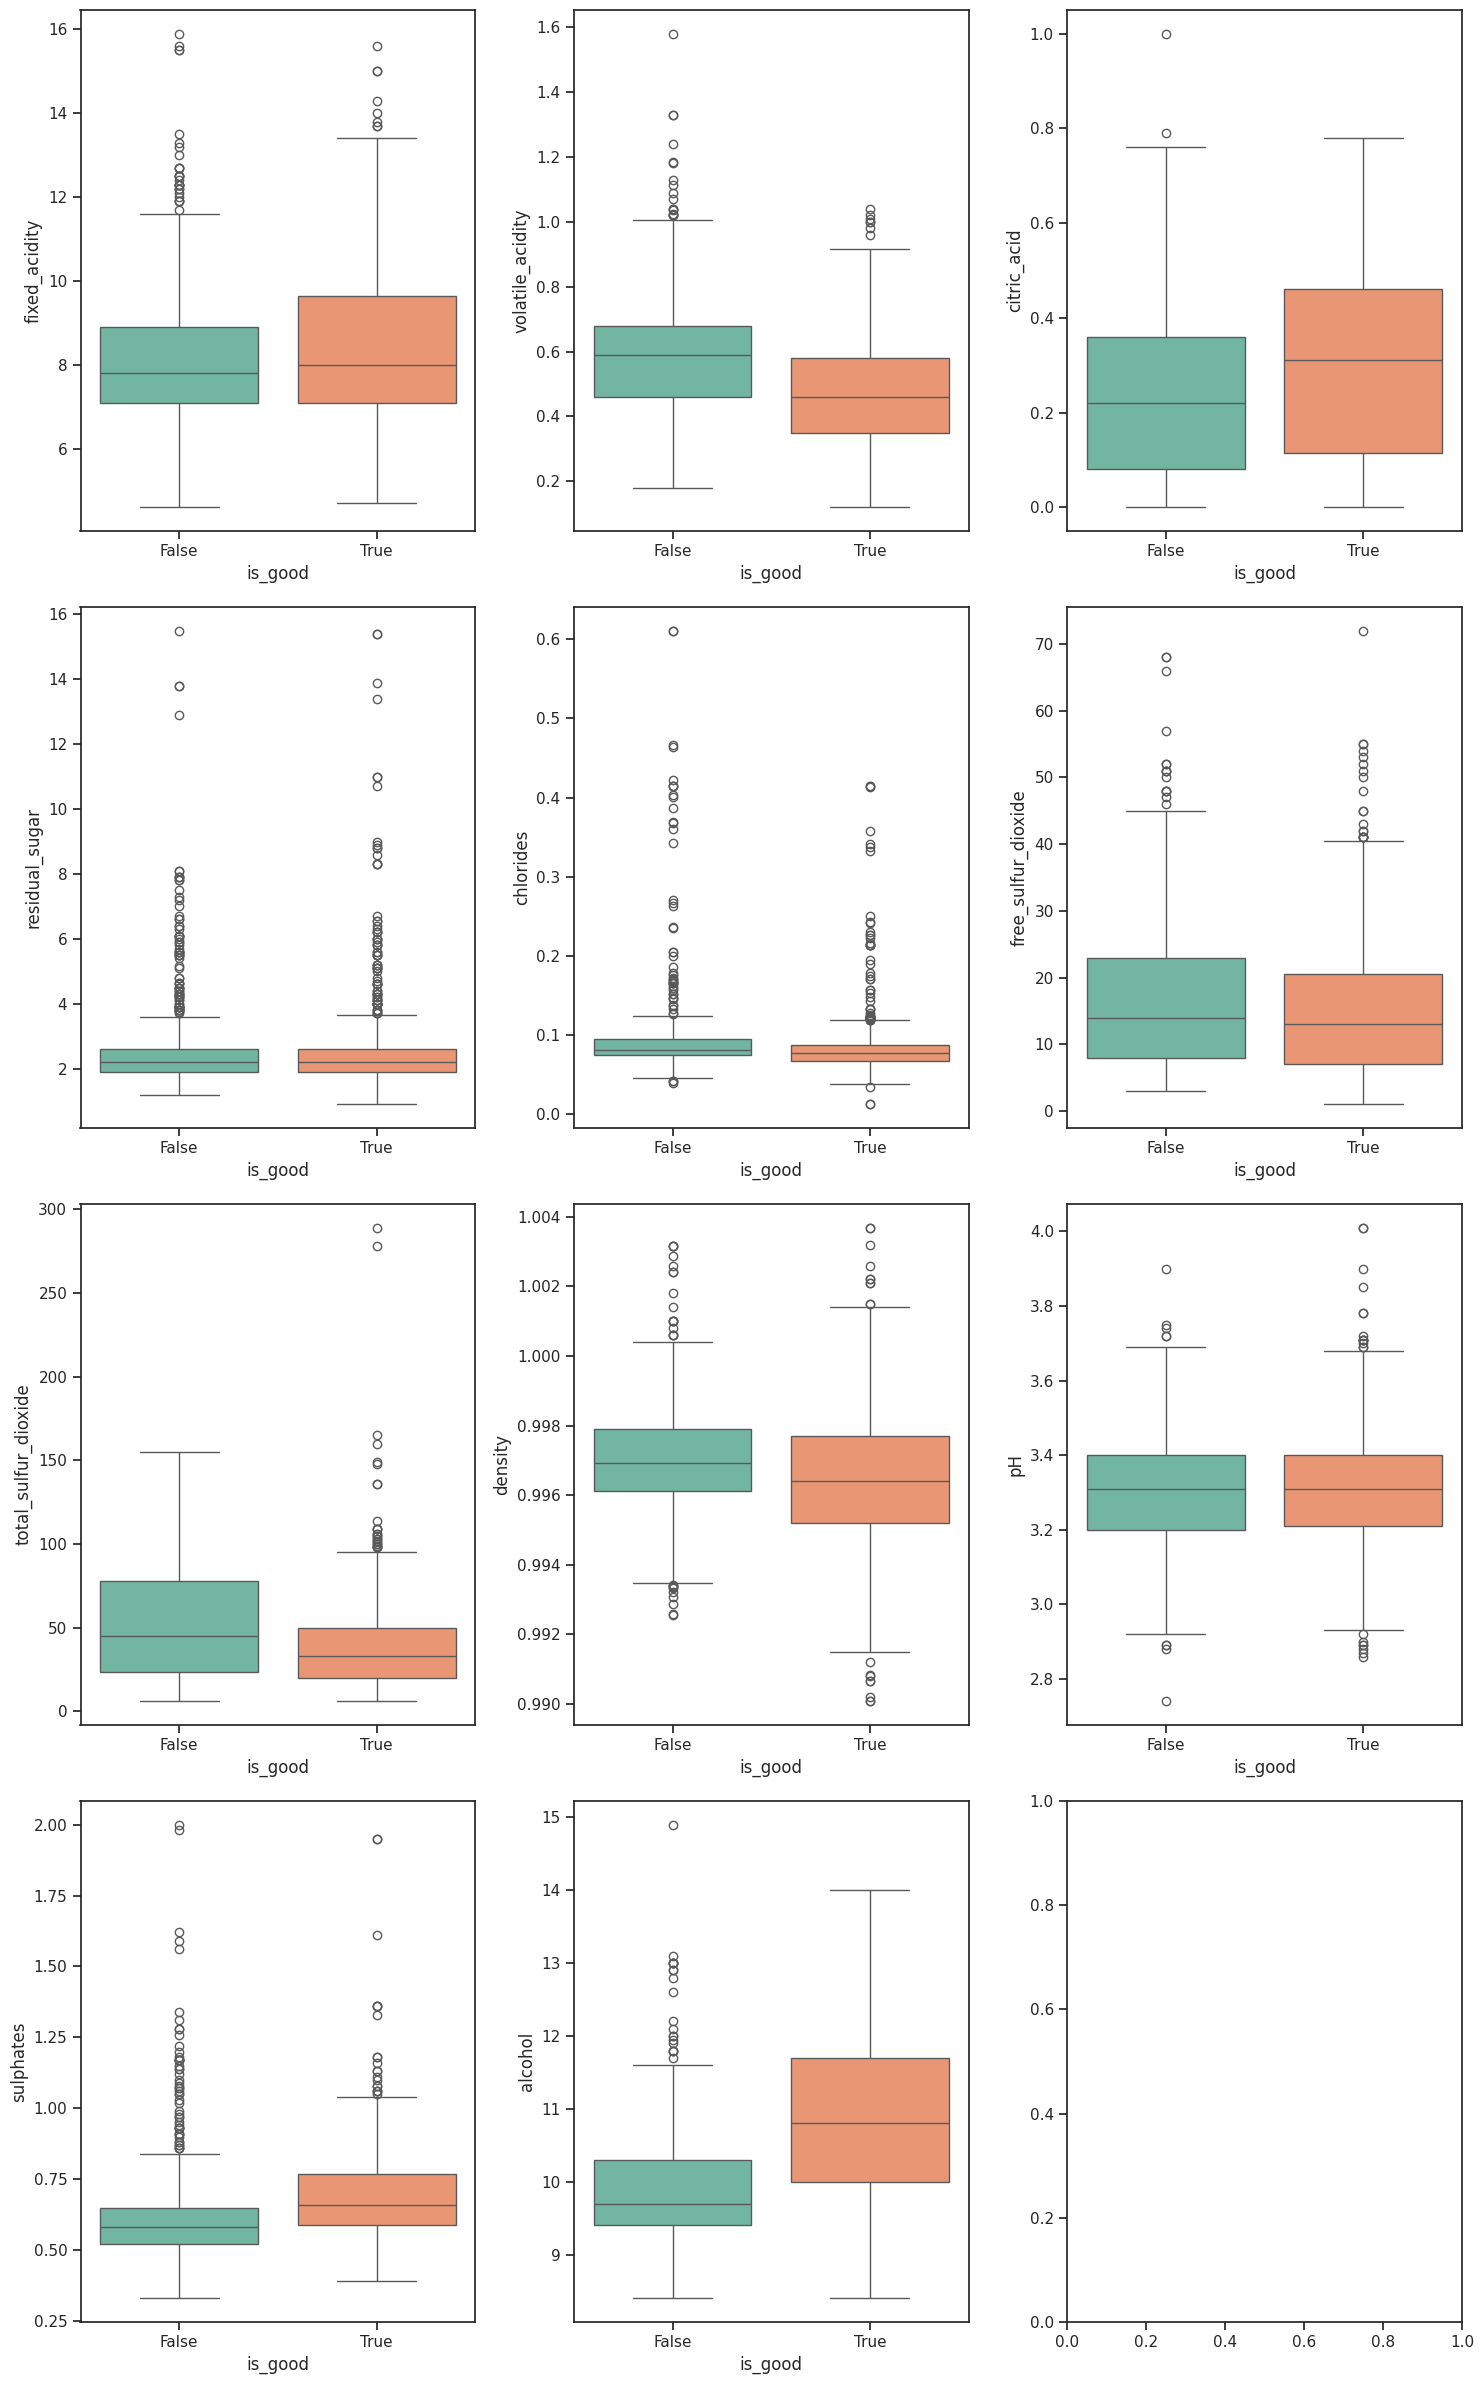

In [8]:
rows = 4
cols = 3
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(5*cols, 6*rows))
axs = axs.flatten()
for i in range(len(predictor_columns)):
    sns.boxplot(x='is_good', y=predictor_columns[i], data=wine_df, ax=axs[i],
                hue='is_good',legend=False)
plt.tight_layout()

There's no single feature that can separate the data perfectly. Alcohol and total sulfur dioxide look somewhat predictive though.

Lets pick a few of the features that look important and plot a pairwise scatterplot matrix.

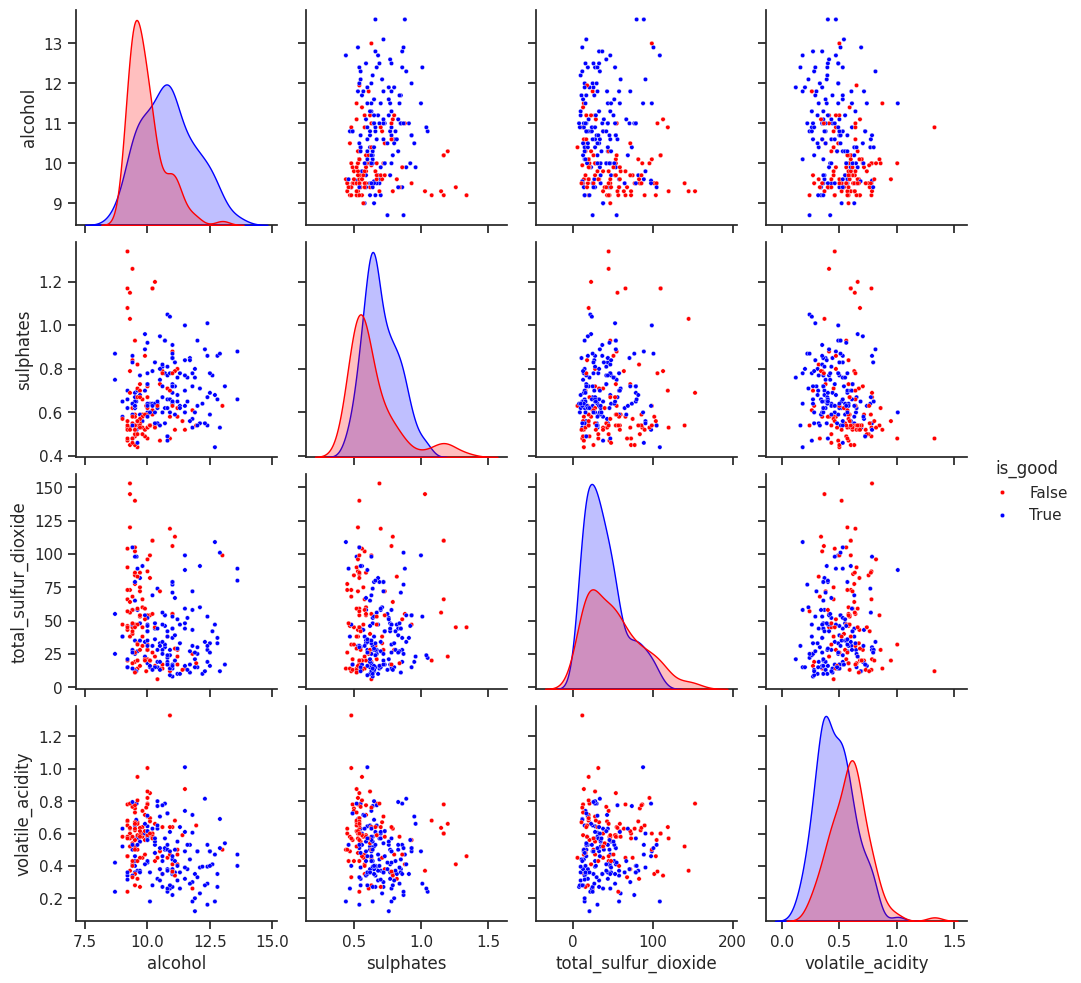

In [9]:
# plot a scatterplot matrix of all of the features
# use a sample of 250 for simplicity

features = ["alcohol", "sulphates","total_sulfur_dioxide","volatile_acidity","is_good"]
sns.pairplot(wine_df[features].sample(250), hue='is_good', palette=['red','blue'], plot_kws={'s': 10})


## Fitting a Decision Tree
Let's now fit a model using a tree.  And in particular, classification trees, since our target is to predict (the probability of) whether the wine is good or not -- binary classification (class probability estimation).

Lets fit a simple - depth = 4 - tree to see which features seem to be most important

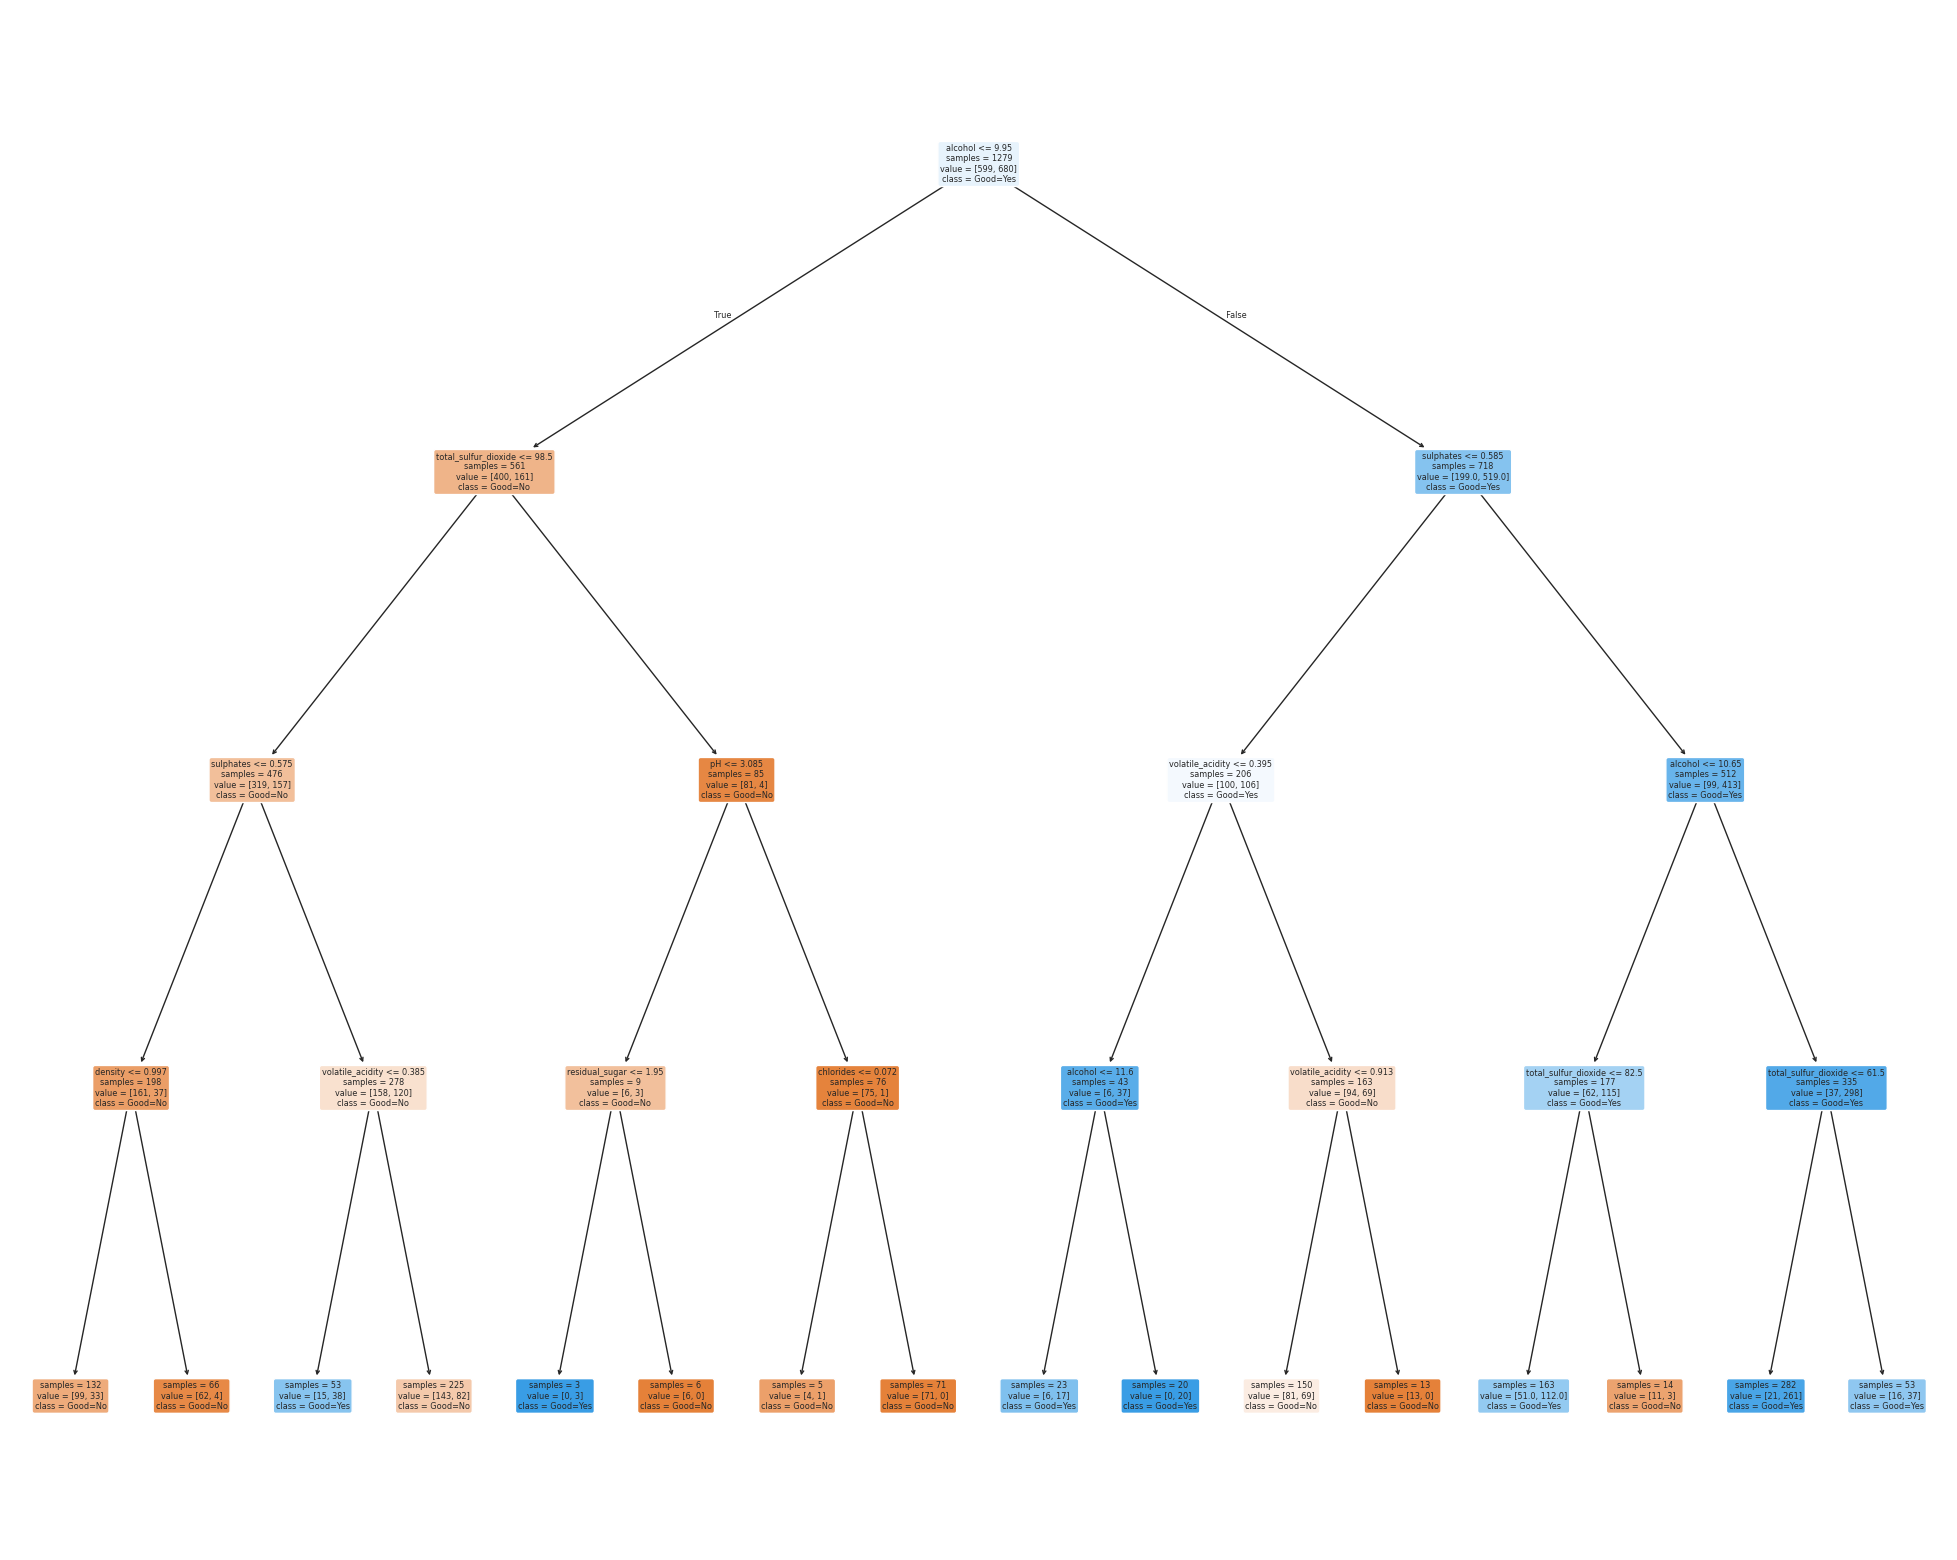

In [10]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score



X = wine_df[predictor_columns]
Y = wine_df.is_good

# split data into train and test

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

model = DecisionTreeClassifier(max_depth=4, criterion="entropy")
model.fit(X_train,Y_train)
plt.figure(figsize=(25,20))
plot_tree(model, feature_names=X.columns, filled=True, class_names=["Good=No", "Good=Yes"], impurity=False, rounded=True)
plt.show()



Lets compare our accuracy metric applied to our Training Data compared to our Test Data.

Which do you think will be better?

In [11]:
# calculate accuracy of the tree as applied to the training data
train_acc = accuracy_score(model.predict(X_train), Y_train)
test_acc = accuracy_score(model.predict(X_test), Y_test)
print ("Training Accuracy = %.4f" % train_acc)
print ("Test Accuracy = %.4f" % test_acc)

Training Accuracy = 0.7647
Test Accuracy = 0.6875


We can extract probabilities from our test set using `predict_proba`.  Lets see what the distribution of probabilities is

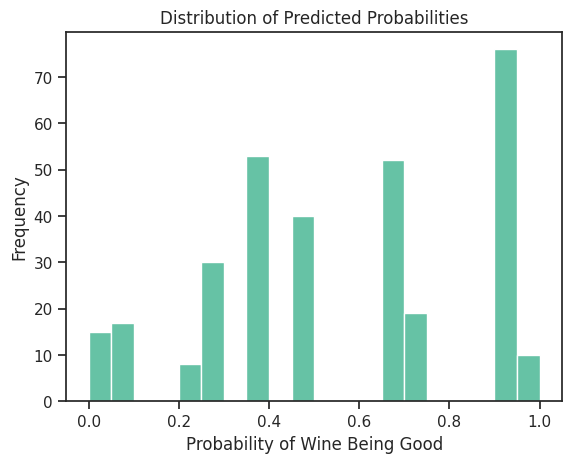

In [12]:
y_probs = model.predict_proba(X_test)[:, 1]

# Plot the probabilities as a histogram
plt.hist(y_probs, bins=20)
plt.xlabel("Probability of Wine Being Good")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.show()

## Complexity Control using `max_depth`

In a prior notebook, we found the best depth of the tree by cycling over max_depth.  Here we will do this again - and plot the complexity vs performance curve.

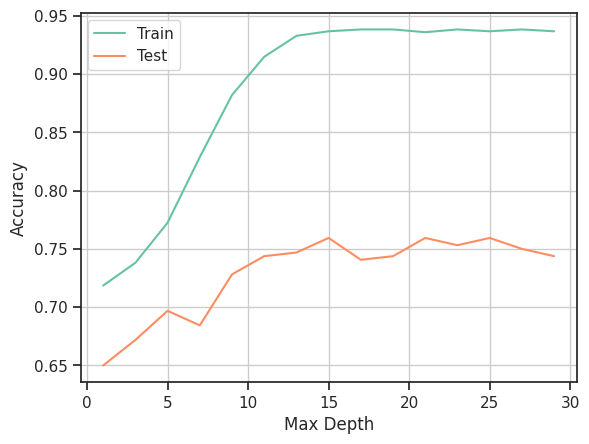

In [13]:
depths_list = np.arange(1,31,2)
train_accs = []
test_accs = []

for depth in depths_list:
  model = DecisionTreeClassifier(max_depth=depth,criterion="entropy",min_samples_leaf=4)
  model.fit(X_train,Y_train)
  train_accs.append(accuracy_score(model.predict(X_train), Y_train))
  test_accs.append(accuracy_score(model.predict(X_test), Y_test))


# plot train_accs and test_accs on same plot as different lines
plt.plot(depths_list, train_accs, label="Train")
plt.plot(depths_list, test_accs, label="Test")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

Hmm - the test performance data does not decrease as we expect it to in this case.  That happens sometimes!  Particularly in cases with small data sets, or when the patterns are not very complicated.  

 In this case, choose a value of the parameter at the point that it "levels off".  Use _Occam's Razor_ : pick the simplest model that has good accuracy.  

## Cross validation

Above, we made a single train/test split. We set aside 20% of our data and *never* used it for training. We also never used the 80% of the data set aside for training to test generalizability.  Note that there are two potential problems with the simple holdout approach.

1) Perhaps the random split was particularly bad (or good).  Do we have any confidence in our accuracy estimate?

2) We are using only 20% of the data for testing.  Could we possibly use the data more fully for testing?

3) Often we want to know something about the distribution of our evaluation metrics. A simple train/test split only allows a single "point estimate"

Instead of only making the split once, let's use **cross-validation** -- every record will contribute to testing as well as to training.


<img src="https://github.com/pearl-yu/foster_2022fall/blob/2022-master/Module3_Fitting_CrossVal/images/cross.png?raw=1" alt="Drawing" style="width: 30px;"/>

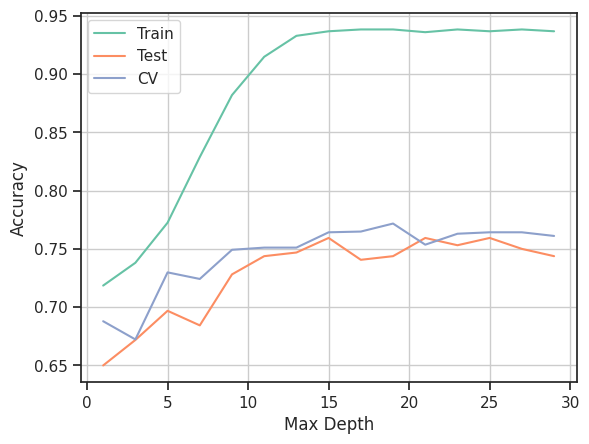

In [14]:
from sklearn.model_selection import cross_val_score, KFold

# this next line ensures that the folds are truly randomized
kf=KFold(n_splits=5, shuffle=True, random_state=12)
cv_accs = []

for depth in depths_list:
  model = DecisionTreeClassifier(max_depth=depth,criterion="entropy")
  scores = cross_val_score(model, X, Y, scoring="accuracy",cv=kf)
  cv_accs.append(scores.mean())


plt.plot(depths_list, train_accs, label="Train")
plt.plot(depths_list, test_accs, label="Test")
plt.plot(depths_list, cv_accs, label="CV")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()


Can also try Leave One Out Cross-Validation.

This will get a better estimate but will take a lot more time!!!

Lets just do one iteration since it takes about a minute for each one..

In [15]:
# will take a few minutes to run!!!!

from sklearn.model_selection import LeaveOneOut, cross_val_score
loo=LeaveOneOut()

depths_list = [1,5,10,15,20,25]
for depth in depths_list:
  model = DecisionTreeClassifier(max_depth=depth,criterion="entropy")
  scores = cross_val_score(model, X, Y, scoring="accuracy",cv=loo)
  print(depth, scores.mean().round(2))




1 0.69
5 0.72
10 0.75
15 0.77
20 0.78
25 0.78


##Grid Search

When fitting trees, `max_depth` is not the only paramter you can tweak for complexity control.  Other include

* `min_samples_split` - the minimum number of samples needed at a node to split
* `min_samples_leaf` - the minimum number of samples that can be in a leaf node
* `max_leaf_nodes` - limits the number of leaf nodes in the overall tree
* `max_features` - limits the features that are considered at each split (removes noise features)
* `min_impurity_decrease` - restricts the ability of the tree to create trivial splits

Each of these have sensible defaults, but it is possible that setting them carefully could result in improved performance.  How can we maximize several of these at once?

**Grid Search** is one way to find optimized parameters across many different options.  And we can use `GridSearchCV()` as a way to optimize across all of our options using cross validation.

First you identify all of your parameters and the grid using `param_grid` and then run `GridSearchCV` which searches all possible combinations:

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
param_grid = {
    'max_depth': [1, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'max_features': [1,3,5,7,9,11]
}

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=13), param_grid, cv=kf, n_jobs=-1,scoring="accuracy")
gridSearch.fit(X,Y)
print('First level optimal parameters: ', gridSearch.best_params_)

First level optimal parameters:  {'max_depth': 20, 'max_features': 3, 'min_samples_split': 2}


Once you learn the general area, you can narrow it down further:




In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
param_grid = {
    'max_depth': [18,19,20,21,22],
    'min_samples_split': [2,3,4],
    'max_features': [2,3,4]
}

gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=kf, n_jobs=-1,scoring="accuracy")
gridSearch.fit(X,Y)
print('Next level optimal parameters: ', gridSearch.best_params_)

The best model (with the optimized parameters) now lives in `gridSearch.best_estimator_`

In [17]:
gridSearch.best_estimator_

DecisionTreeClassifier(max_depth=20, max_features=3, random_state=13)

## Model Performance
All of this is just to find the optimal depth of our tree!  Once we have found it, we want to use it to see how well it predicts on the test set.  Pick your best tree size, and fit your "final model" to the training data.  Look at the matrix of truth vs. Prediction on the test set - called the *Confusion Matrix*.  

In [18]:
# first, lets see what our overall accuracy is:

print('Average accuracy from GridSearchCV: ', gridSearch.best_score_.round(3))

Average accuracy from GridSearchCV:  0.776


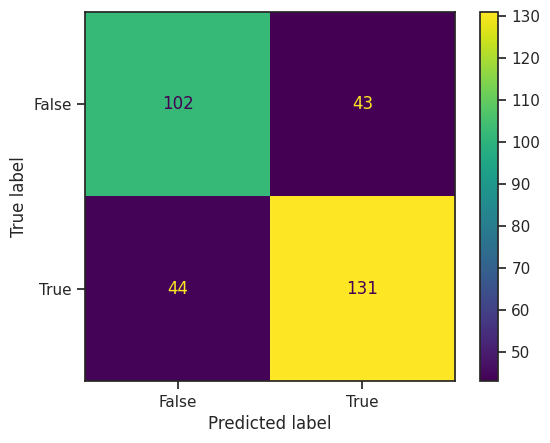

In [19]:
# calculate a confusion matrix using the best estimator from GridSearch

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model = gridSearch.best_estimator_
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(Y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()


In [20]:
# what are the feature importances?

importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)
print("Feature Importances:")
print(feature_importances.round(4))

Feature Importances:
alcohol                 0.2514
sulphates               0.1141
volatile_acidity        0.0954
total_sulfur_dioxide    0.0885
pH                      0.0793
free_sulfur_dioxide     0.0741
citric_acid             0.0718
residual_sugar          0.0612
density                 0.0578
chlorides               0.0576
fixed_acidity           0.0488
dtype: float64


# Async Assignment:  Apply to HW1 Data (HudsonU)

Lets do the same comparison for our HW1 data, from HudsonU (data availabe on Brightspace under DataSets).

Create a target which is an indicator as to whether or not the Chance of Admission is greater than 0.5.  Then find the optimal `max_depth`.

Fill in the ### values below to complete the task, and report on your Async Assessment your optimal max_depth and the accuracy value  of that depth

In [ ]:
## First import HudsonU data into Colab

In [21]:
admissions=pd.read_csv("HudsonU.csv")

admissions=admissions.rename(columns={"Serial No.": "ID", "GRE Score": "GRE","TOEFL Score":"TOEFL","University Rating":"Rating","Chance of Admit":"Admit"})

admissions.head()


,ID,GRE,TOEFL,Rating,SOP,LOR,CGPA,Research,Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [23]:
# define our

X = admissions[['GRE', 'TOEFL', 'Rating', 'SOP', 'LOR', 'CGPA', 'Research']]
y = admissions['Admit']> 0.5

# split into test set and training set using 20% for test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.2,random_state=8)

In [27]:
# Create a depths_list from 2 to 20 and cycle through to find the optimal depth
# store the CV scores in cv_accs

depths_list = np.arange(2,21,1)

cv_accs = []
kf=KFold(n_splits=5, shuffle=True)

for depth in depths_list:
  model = DecisionTreeClassifier(max_depth=depth,criterion="entropy")
  model.fit(X,y)
  scores = cross_val_score(model, X, y, scoring="accuracy",cv=kf)
  cv_accs.append(scores.mean())

# print out the values of depth_list and cv_accs to see which value of max_depth has the best accuracy

# Find the depth with the highest average CV accuracy
best_index = np.argmax(cv_accs)
best_depth = depths_list[best_index]
best_accuracy = cv_accs[best_index]

# Print results
print("Depths tested:", depths_list)
print("Cross-validation accuracies:", np.round(cv_accs, 4))
print(f"\nBest max_depth: {best_depth}")
print(f"Best CV Accuracy: {best_accuracy:.4f}")
# report max_depth and its accuracy in the Async Asssessment

Depths tested: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Cross-validation accuracies: [0.928 0.932 0.914 0.922 0.906 0.916 0.902 0.912 0.894 0.906 0.902 0.89
 0.894 0.904 0.874 0.9   0.904 0.9   0.894]

Best max_depth: 3
Best CV Accuracy: 0.9320
